In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv
/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv


* The objective is to predict the daily audience count for various theaters based on historical booking data from two platforms: BookNow (online) and CinePOS (on-site).

# Milestone 1
**. Importing Libraries** 
* Import basics + set display options for clarity 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import gc

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set a color palette for our plots to make them look nice
sns.set_palette('viridis')

# 1. Data Loading
"I'm starting to load my data. In this cell, I load most of the CSV files into pandas DataFrames.

In [4]:
# --- Load all CSVs directly ---
dtype_spec = {'book_theater_id': 'category', 'cine_theater_id': 'category'}

movie_theater_id_relation_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/movie_theater_id_relation/movie_theater_id_relation.csv', dtype=dtype_spec)
date_info_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/date_info/date_info.csv', parse_dates=['show_date'])
sample_submission_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/sample_submission/sample_submission.csv')
booknow_theaters_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_theaters/booknow_theaters.csv', dtype=dtype_spec)
cinepos_theaters_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_theaters/cinePOS_theaters.csv', dtype=dtype_spec)
booknow_visits_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_visits/booknow_visits.csv', dtype=dtype_spec, parse_dates=['show_date'])


In [5]:
print("movie_theater_id_relation_df")
movie_theater_id_relation_df.head()


movie_theater_id_relation_df


,book_theater_id,cine_theater_id
0,book_00509,cinePOS_01261
1,book_00063,cinePOS_02467
2,book_00054,cinePOS_08923
3,book_00094,cinePOS_02479
4,book_00052,cinePOS_06750


In [6]:
print("date_info_df")
date_info_df.head()

date_info_df


,show_date,day_of_week
0,2023-01-01,Sunday
1,2023-01-02,Monday
2,2023-01-03,Tuesday
3,2023-01-04,Wednesday
4,2023-01-05,Thursday


In [7]:
print("sample_submission_df")
sample_submission_df.head()

sample_submission_df


,ID,audience_count
0,book_00001_2024-03-01,0
1,book_00001_2024-03-02,0
2,book_00001_2024-03-03,0
3,book_00001_2024-03-04,0
4,book_00001_2024-03-06,0


In [8]:
print("booknow_theaters_df")
booknow_theaters_df.head()

booknow_theaters_df


,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515


In [9]:
print("cinepos_theaters_df")
cinepos_theaters_df.head()

cinepos_theaters_df


,cine_theater_id,theater_type,theater_area,latitude,longitude
0,cinePOS_05466,Other,Area_104,22.619233,78.113017
1,cinePOS_08708,Other,Area_104,22.619233,78.113017
2,cinePOS_00753,Other,Area_104,22.619233,78.113017
3,cinePOS_05776,Other,Area_104,22.619233,78.113017
4,cinePOS_07536,Other,Area_104,23.004410,79.934515


In [10]:
print("booknow_visits_df")
booknow_visits_df.head()

booknow_visits_df


,book_theater_id,show_date,audience_count
0,book_00001,2023-01-13,50
1,book_00001,2023-01-14,64
2,book_00001,2023-01-15,58
3,book_00001,2023-01-16,44
4,book_00001,2023-01-18,12


In [11]:
# For the largest files, load only necessary columns to save memory
cinepos_booking_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/cinePOS_booking/cinePOS_booking.csv',
                                 dtype=dtype_spec, usecols=['cine_theater_id', 'show_datetime', 'tickets_sold'], 
                                 parse_dates=['show_datetime'])

In [12]:
cinepos_booking_df.head()

,cine_theater_id,show_datetime,tickets_sold
0,cinePOS_00001,2023-01-01 11:00:00,1
1,cinePOS_00002,2023-01-01 13:00:00,3
2,cinePOS_00003,2023-01-01 16:00:00,2
3,cinePOS_00004,2023-01-01 17:00:00,5
4,cinePOS_00005,2023-01-01 17:00:00,13


In [13]:
booknow_booking_df = pd.read_csv('/kaggle/input/Cinema_Audience_Forecasting_challenge/booknow_booking/booknow_booking.csv', 
                                 dtype=dtype_spec, usecols=['book_theater_id', 'show_datetime', 'booking_datetime', 'tickets_booked'], 
                                 parse_dates=['show_datetime', 'booking_datetime'])

In [14]:
booknow_booking_df.head()

,book_theater_id,show_datetime,booking_datetime,tickets_booked
0,book_00244,2023-01-01 19:00:00,2023-01-01 16:00:00,1
1,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,3
2,book_00740,2023-01-01 19:00:00,2023-01-01 19:00:00,6
3,book_00244,2023-01-01 20:00:00,2023-01-01 16:00:00,2
4,book_00151,2023-01-01 20:00:00,2023-01-01 01:00:00,5


In [15]:
# #What is the shape of the dataset named booknow_booking?
# # Get the shape of the booknow_booking_df DataFrame
# shape = booknow_booking_df.shape

# # Print the shape
# print(shape)

# # How many columns are of type Object in the dataset named cinePOS_theaters?
# # Select columns of type 'Object'
# object_columns = cinepos_theaters_df.select_dtypes(include=['object']).columns

# # Print the number of object columns
# print(len(object_columns))


# # Which of the following theater types is the most frequent in the dataset named booknow_theaters?
# # Find the most frequent theater type
# most_frequent_theater_type = booknow_theaters_df['theater_type'].mode()[0]

# # Print the most frequent theater type
# print(most_frequent_theater_type)


# # How many distinct theaters are present in the dataset named cinePOS_booking?
# # Count the number of distinct theaters
# distinct_theaters = cinepos_booking_df['cine_theater_id'].nunique()

# # Print the number of distinct theaters
# print(distinct_theaters)


# # Combine the datasets booknow_booking and booknow_theaters. What is the shape of this dataset?
# # Merge the two DataFrames using an inner join
# merged_df = pd.merge(booknow_booking_df, booknow_theaters_df, on='book_theater_id', how='inner')

# # Get the shape of the merged DataFrame
# shape = merged_df.shape

# # Print the shape
# print(shape)


# # Based on the combined dataset obtained in the previous question, how many distinct areas are the theaters located in?
# # Count the number of distinct theater areas in the merged DataFrame
# distinct_areas = merged_df['theater_area'].nunique()

# # Print the number of distinct areas
# print(distinct_areas)


# # Combine the datasets movie_theater_id_relation, cinePOS_booking and cinePOS_theaters. Enter the column names containing missing values as comma seperated values
# # First, merge movie_theater_id_relation and cinePOS_booking DataFrames
# merged_df1 = pd.merge(movie_theater_id_relation_df, cinepos_booking_df, on='cine_theater_id', how='inner')

# # Now, merge the result with the cinePOS_theaters DataFrame
# final_merged_df = pd.merge(merged_df1, cinepos_theaters_df, on='cine_theater_id', how='inner')

# # Find columns that have missing values
# missing_values = final_merged_df.isnull().sum()
# columns_with_missing_values = missing_values[missing_values > 0].index.tolist()

# # Print the column names as a comma-separated string
# print(','.join(columns_with_missing_values))


# # Enter the date range spanned in the dataset named booknow_booking.
# # Convert the 'show_datetime' column to datetime objects
# booknow_booking_df['show_datetime'] = pd.to_datetime(booknow_booking_df['show_datetime'])

# # Find the earliest and latest dates
# start_date = booknow_booking_df['show_datetime'].min()
# end_date = booknow_booking_df['show_datetime'].max()

# # Format the dates in "dd-mm-yyyy" format
# formatted_start_date = start_date.strftime('%d-%m-%Y')
# formatted_end_date = end_date.strftime('%d-%m-%Y')

# # Print the date range
# print(f"{formatted_start_date} to {formatted_end_date}")


# #  Enter the date range spanned in the test dataset (sample_submission).
# # Extract the date part from the 'ID' column
# sample_submission_df['show_date'] = sample_submission_df['ID'].apply(lambda x: x.split('_')[-1])

# # Convert the 'show_date' column to datetime objects
# sample_submission_df['show_date'] = pd.to_datetime(sample_submission_df['show_date'])

# # Find the earliest and latest dates
# start_date = sample_submission_df['show_date'].min()
# end_date = sample_submission_df['show_date'].max()

# # Format the dates in "dd-mm-yyyy" format
# formatted_start_date = start_date.strftime('%d-%m-%Y')
# formatted_end_date = end_date.strftime('%d-%m-%Y')

# # Print the date range
# print(f"{formatted_start_date} to {formatted_end_date}")

# 2. Exploratory Data Analysis
**Let's explore the data to understand trends and patterns in cinema attendance. This will help us make better decisions when building the model later.**
# . Data Visualization
  **Time Series of Total Audience Count :**
  This plot helps me see the overall trend of ticket sales over time

In [16]:
# Group by date and sum the audience count to get the daily total
daily_audience = booknow_visits_df.groupby('show_date')['audience_count'].sum().reset_index()

In [17]:
daily_audience.head()

,show_date,audience_count
0,2023-01-01,2066
1,2023-01-02,3528
2,2023-01-03,4736
3,2023-01-04,6652
4,2023-01-05,7854


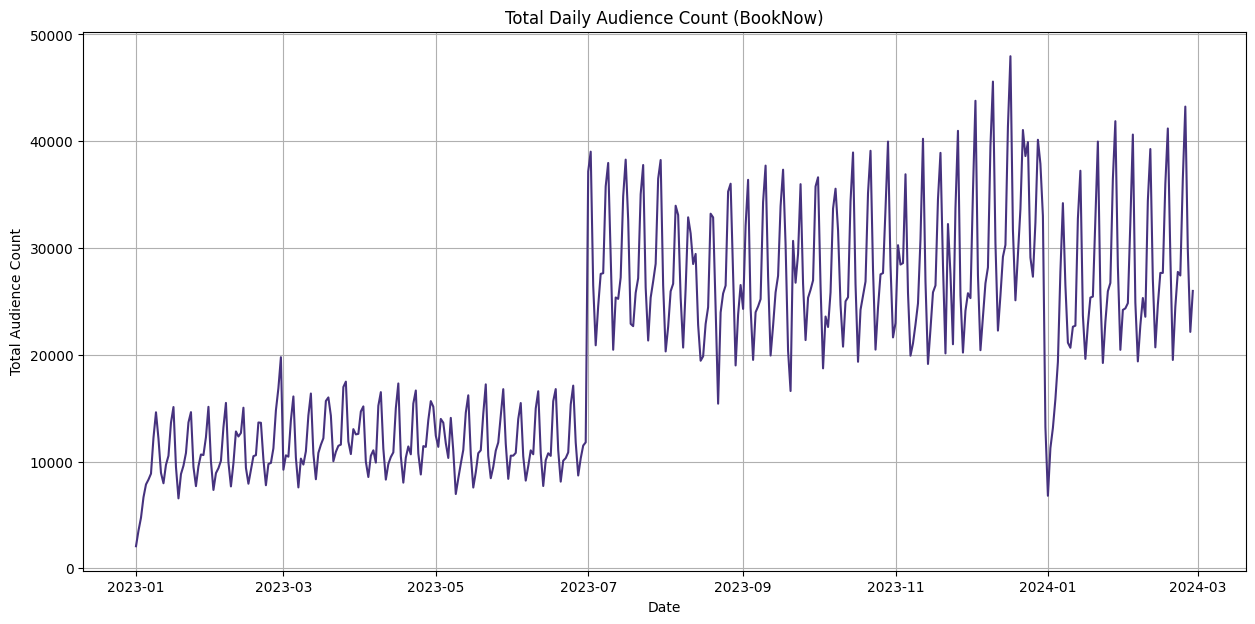

In [18]:
# Plot the time series
plt.figure(figsize=(15, 7))
sns.lineplot(x='show_date', y='audience_count', data=daily_audience)
plt.title('Total Daily Audience Count (BookNow)')
plt.xlabel('Date')
plt.ylabel('Total Audience Count')
plt.grid(True)
plt.show()

 **Distribution of Audience Count :**
    This shows me the distribution of my target variable.

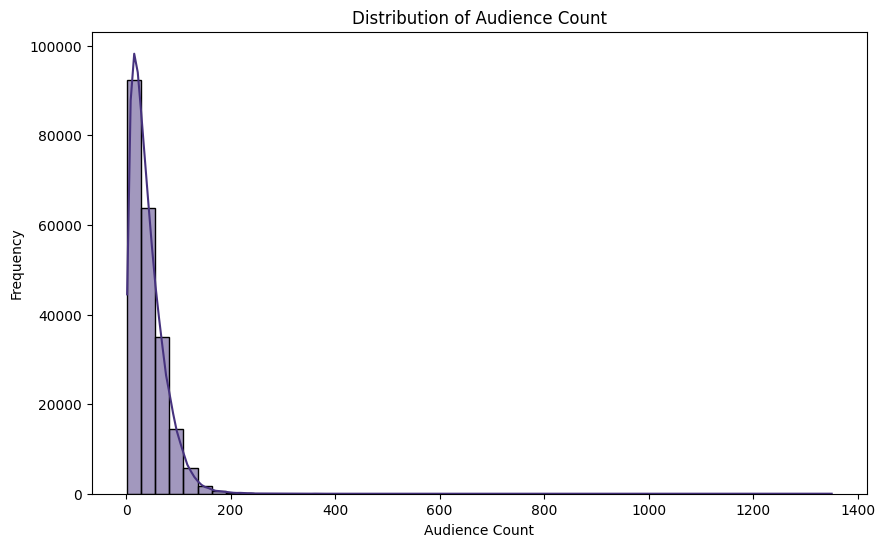

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(booknow_visits_df['audience_count'].dropna(), bins=50, kde=True)
plt.title('Distribution of Audience Count')
plt.xlabel('Audience Count')
plt.ylabel('Frequency')
plt.show()

Most days probably have low attendance, with a few blockbuster days (long tail). This confirms it's a regression problem.

**Audience Count by Day of the Week :**
    I want to see if the day of the week matters

In [20]:
# Merge with date_info_df to get the day of the week
visits_with_day = pd.merge(booknow_visits_df, date_info_df, on='show_date', how='left')

In [21]:
visits_with_day.head()

,book_theater_id,show_date,audience_count,day_of_week
0,book_00001,2023-01-13,50,Friday
1,book_00001,2023-01-14,64,Saturday
2,book_00001,2023-01-15,58,Sunday
3,book_00001,2023-01-16,44,Monday
4,book_00001,2023-01-18,12,Wednesday


In [22]:
# Group by day of the week and calculate the average audience
audience_by_day = visits_with_day.groupby('day_of_week')['audience_count'].mean().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [23]:
audience_by_day.head()

day_of_week
Monday       47.623494
Tuesday      35.039099
Wednesday    35.220707
Thursday     37.992760
Friday       37.626460
Name: audience_count, dtype: float64

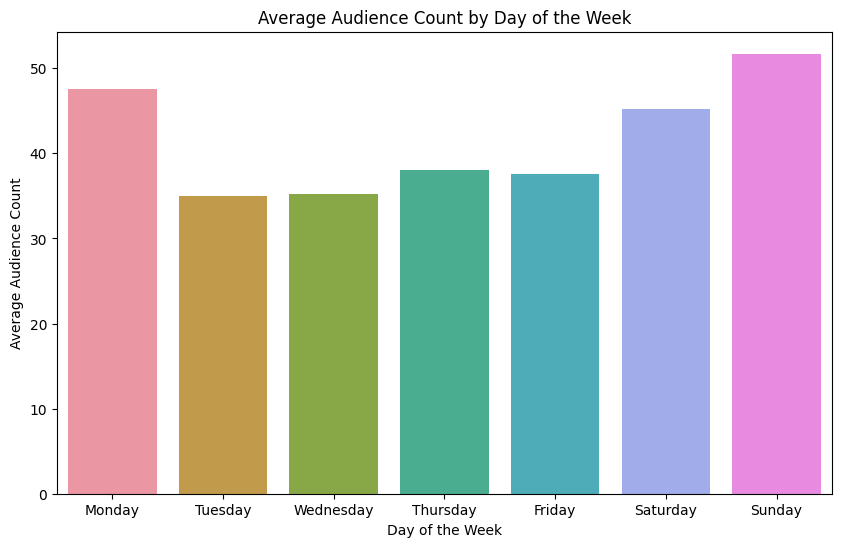

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(x=audience_by_day.index, y=audience_by_day.values)
plt.title('Average Audience Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Audience Count')
plt.show()

As expected, Saturday and Sunday have the highest average audience count.

**Number of Theaters per Area :**
  This is a horizontal bar chart that counts how many theaters are in each theater_area. 

In [25]:
# 1. Get the list of the top 20 theater areas
top_20_areas = booknow_theaters_df['theater_area'].value_counts().index[:20]

# 2. Filter the original DataFrame to only include rows for these top 20 areas
top_20_df = booknow_theaters_df[booknow_theaters_df['theater_area'].isin(top_20_areas)]

In [26]:
top_20_areas

Index(['Area_003', 'Area_006', 'Area_002', 'Area_010', 'Area_004', 'Area_018',
       'Area_005', 'Area_008', 'Area_011', 'Area_016', 'Area_007', 'Area_020',
       'Area_021', 'Area_001', 'Area_029', 'Area_014', 'Area_053', 'Area_009',
       'Area_015', 'Area_025'],
      dtype='object', name='theater_area')

In [27]:
top_20_df.head()

,book_theater_id,theater_type,theater_area,latitude,longitude
0,book_00093,Drama,Area_001,22.619233,78.113017
1,book_00078,Drama,Area_001,22.619233,78.113017
2,book_00291,Drama,Area_001,22.619233,78.113017
3,book_00258,Drama,Area_001,22.619233,78.113017
4,book_00212,Drama,Area_002,23.004410,79.934515


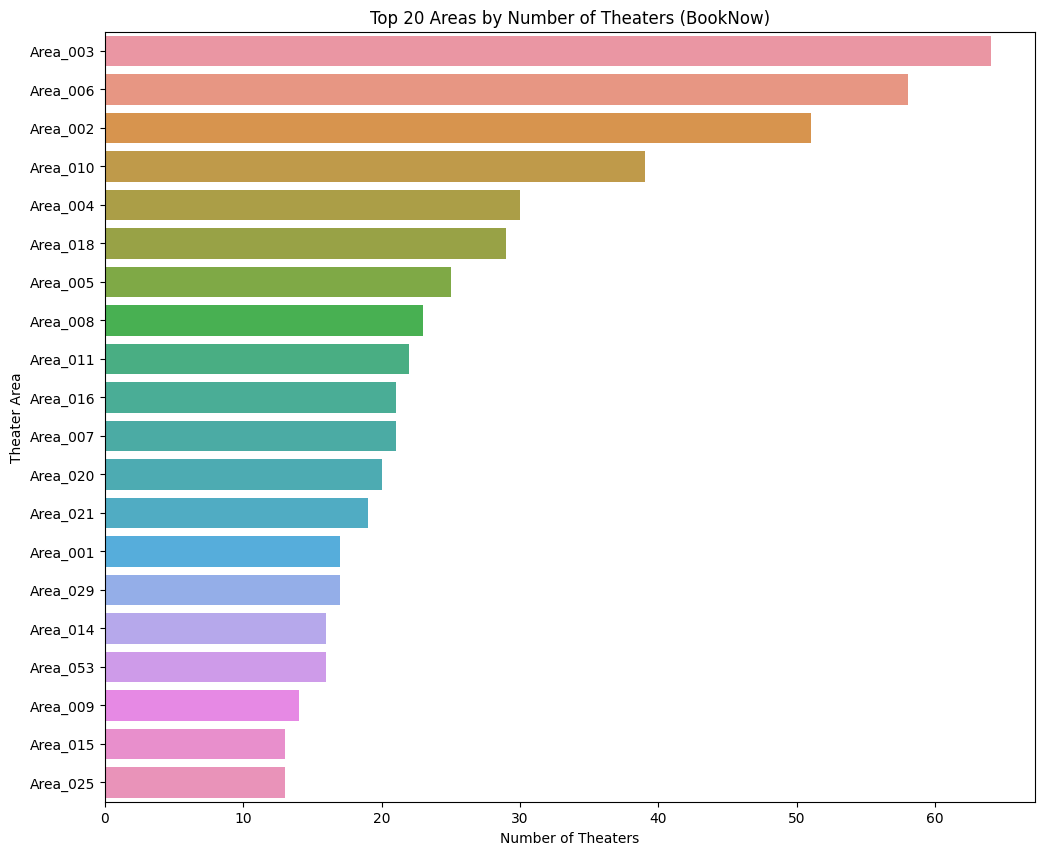

In [28]:
# 3. Plot this new, filtered DataFrame
#    I made the figure slightly taller (figsize=(12, 10)) to give the 20 bars more space
plt.figure(figsize=(12, 10))

#    We plot the 'top_20_df' and use 'top_20_areas' for the order
sns.countplot(y='theater_area', data=top_20_df, order=top_20_areas)

plt.title('Top 20 Areas by Number of Theaters (BookNow)') 
plt.xlabel('Number of Theaters')
plt.ylabel('Theater Area')
plt.show()

**Distribution of Theater Types :**
 This quickly shows me which types (like 'Multiplex') are the most common in my data.

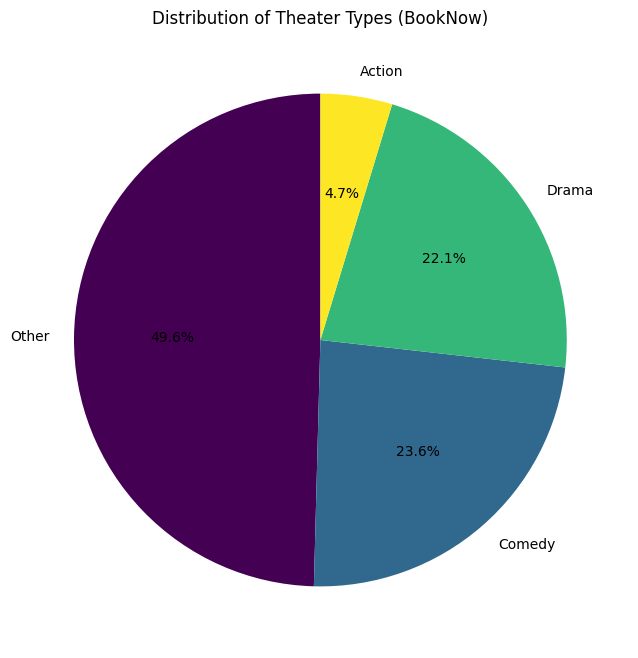

In [29]:
plt.figure(figsize=(8, 8))
booknow_theaters_df['theater_type'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, cmap='viridis')
plt.title('Distribution of Theater Types (BookNow)')
plt.ylabel('') # Hide the y-label for a cleaner look
plt.show()

# . Statistical Analysis
   Let's look at some basic statistics of data and check for missing values.

In [30]:
# Descriptive Statistics for main dataset
print(booknow_visits_df.describe())

                           show_date  audience_count
count                         214046   214046.000000
mean   2023-09-13 04:07:24.285807360       41.616568
min              2023-01-01 00:00:00        2.000000
25%              2023-07-09 00:00:00       18.000000
50%              2023-09-25 00:00:00       34.000000
75%              2023-12-11 00:00:00       58.000000
max              2024-02-28 00:00:00     1350.000000
std                              NaN       32.834918


In [31]:
# Check for missing values in all dataframes
for df_name, df in zip(['movie_theater_id_relation_df', 'date_info_df', 'sample_submission_df', 'booknow_theaters_df', 'cinepos_theaters_df', 'booknow_visits_df', 'cinepos_booking_df', 'booknow_booking_df'],
                       [movie_theater_id_relation_df, date_info_df, sample_submission_df, booknow_theaters_df, cinepos_theaters_df, booknow_visits_df, cinepos_booking_df, booknow_booking_df]):
    print(f"\nMissing values in {df_name}:")
    print(df.isnull().sum())


Missing values in movie_theater_id_relation_df:
book_theater_id    0
cine_theater_id    0
dtype: int64

Missing values in date_info_df:
show_date      0
day_of_week    0
dtype: int64

Missing values in sample_submission_df:
ID                0
audience_count    0
dtype: int64

Missing values in booknow_theaters_df:
book_theater_id    515
theater_type         0
theater_area         0
latitude             0
longitude            0
dtype: int64

Missing values in cinepos_theaters_df:
cine_theater_id       0
theater_type          0
theater_area          0
latitude           3861
longitude          3861
dtype: int64

Missing values in booknow_visits_df:
book_theater_id    0
show_date          0
audience_count     0
dtype: int64

Missing values in cinepos_booking_df:
cine_theater_id    0
show_datetime      0
tickets_sold       0
dtype: int64

Missing values in booknow_booking_df:
book_theater_id     0
show_datetime       0
booking_datetime    0
tickets_booked      0
dtype: int64


* # Data Cleaning and Preprocessing
    This is a crucial step. We need to prepare our data in a way that our machine learning model can understand. We will merge the different data sources, create new features, and handle missing values and categorical variables.

* Creating a Master DataFrame 
   * Let's combine all our information into a single master DataFrame. 

In [32]:
# This makes the large CinePOS booking file much smaller and easier to work with.
#"Step 1: Aggregating the CinePOS booking data..."
cinepos_booking_df['show_date'] = cinepos_booking_df['show_datetime'].dt.date

In [33]:
cinepos_daily_audience = cinepos_booking_df.groupby(['cine_theater_id', 'show_date'])['tickets_sold'].sum().reset_index()

In [34]:
cinepos_daily_audience.rename(columns={'tickets_sold': 'cinepos_audience_count'}, inplace=True)

In [35]:
cinepos_daily_audience['show_date'] = pd.to_datetime(cinepos_daily_audience['show_date'])

In [36]:
##Aggregating the BookNow booking data..
booknow_booking_df['show_date'] = booknow_booking_df['show_datetime'].dt.date
booknow_daily_audience = booknow_booking_df.groupby(['book_theater_id', 'show_date'])['tickets_booked'].sum().reset_index()
booknow_daily_audience.rename(columns={'tickets_booked': 'booknow_audience_count'}, inplace=True)
booknow_daily_audience['show_date'] = pd.to_datetime(booknow_daily_audience['show_date'])

In [37]:
# booknow_daily_audience.tail()
# cinepos_daily_audience.tail()

In [38]:
# --- Part 2: Merge all data sources into a Master DataFrame ---
# Start with our main dataset, booknow_visits_df, which contains the target variable 'audience_count'.
# i will add other information to this.
df_merged = booknow_visits_df.copy()

In [39]:
# --Merge the aggregated BookNow data ---
df_merged = pd.merge(df_merged, booknow_daily_audience, on=['book_theater_id', 'show_date'], how='left')

In [40]:
# Fill missing online sales with 0
df_merged['booknow_audience_count'] = df_merged['booknow_audience_count'].fillna(0)

In [41]:
# Add theater information (like type and area) from booknow_theaters_df.
# This is the step that adds the 'theater_area' column.
df_merged = pd.merge(df_merged, booknow_theaters_df, on='book_theater_id', how='left')

In [42]:
# Add date information (like day of the week) from date_info_df.
df_merged = pd.merge(df_merged, date_info_df, on='show_date', how='left')

In [43]:
# Now, let's add the CinePOS data. We need the relation file to link CinePOS IDs to BookNow IDs.
cinepos_df = pd.merge(cinepos_daily_audience, movie_theater_id_relation_df, on='cine_theater_id', how='left')
df_merged = pd.merge(df_merged, cinepos_df.drop('cine_theater_id', axis=1), on=['book_theater_id', 'show_date'], how='left')

In [44]:
# If a theater had no CinePOS sales on a given day, the count will be missing (NaN). We should fill these with 0.
df_merged['cinepos_audience_count'] = df_merged['cinepos_audience_count'].fillna(0)

In [45]:
# Sort by date for good practice in time-series data.
df_merged = df_merged.sort_values(by='show_date').reset_index(drop=True)

In [46]:
#("Columns available in the master DataFrame after merging:")
print(df_merged.columns.tolist())
#print("Master DataFrame created successfully.")

['book_theater_id', 'show_date', 'audience_count', 'booknow_audience_count', 'theater_type', 'theater_area', 'latitude', 'longitude', 'day_of_week', 'cinepos_audience_count']


In [47]:
# Feature Engineering (Lags & Rolling Windows)
# done BEFORE the train/val split to prevent data leakage.
# First, sort by theater and date to make sure the shifts are correct.
#("Starting time-series feature engineering")
df_merged = df_merged.sort_values(by=['book_theater_id', 'show_date'])

In [48]:
df_merged.head()

,book_theater_id,show_date,audience_count,booknow_audience_count,theater_type,theater_area,latitude,longitude,day_of_week,cinepos_audience_count
2578,book_00001,2023-01-13,50,0.0,Drama,Area_002,23.00441,79.934515,Friday,0.0
2782,book_00001,2023-01-14,64,0.0,Drama,Area_002,23.00441,79.934515,Saturday,0.0
3063,book_00001,2023-01-15,58,0.0,Drama,Area_002,23.00441,79.934515,Sunday,0.0
3316,book_00001,2023-01-16,44,0.0,Drama,Area_002,23.00441,79.934515,Monday,0.0
3684,book_00001,2023-01-18,12,0.0,Drama,Area_002,23.00441,79.934515,Wednesday,0.0


In [49]:
def create_ts_features(df, group_col='book_theater_id', target='audience_count'):
    """Creates lag and rolling features for the target variable."""
    df_out = df.copy()
    # --- Lag Features ---
    # We shift by 1 to get the previous day, 7 for last week, 14 for two weeks ago
    lags = [1, 7, 14]
    for lag in lags:
        # shift() moves data down, so we get the value from 'lag' days ago
        df_out[f'{target}_lag_{lag}'] = df_out.groupby(group_col)[target].shift(lag)

    # --- Rolling Window Features ---
    # We use shift(1) first so that we are only looking at *past* data (not the current day)
    shifted_target = df_out.groupby(group_col)[target].shift(1)
    
    # 7-day rolling average
    df_out[f'{target}_roll_mean_7'] = shifted_target.rolling(7, min_periods=1).mean()
    
    # 14-day rolling average
    df_out[f'{target}_roll_mean_14'] = shifted_target.rolling(14, min_periods=1).mean()
    
    # 7-day rolling max
    df_out[f'{target}_roll_max_7'] = shifted_target.rolling(7, min_periods=1).max()
    
    # 7-day rolling standard deviation (volatility)
    df_out[f'{target}_roll_std_7'] = shifted_target.rolling(7, min_periods=1).std()

    return df_out
    

In [50]:
# Apply this to both the main target (audience_count) and the POS data
df_merged = create_ts_features(df_merged, group_col='book_theater_id', target='audience_count')
df_merged = create_ts_features(df_merged, group_col='book_theater_id', target='cinepos_audience_count')
df_merged = create_ts_features(df_merged, group_col='book_theater_id', target='booknow_audience_count')

In [51]:
df_merged.tail(20)

,book_theater_id,show_date,audience_count,booknow_audience_count,theater_type,theater_area,latitude,longitude,day_of_week,cinepos_audience_count,...,cinepos_audience_count_roll_mean_14,cinepos_audience_count_roll_max_7,cinepos_audience_count_roll_std_7,booknow_audience_count_lag_1,booknow_audience_count_lag_7,booknow_audience_count_lag_14,booknow_audience_count_roll_mean_7,booknow_audience_count_roll_mean_14,booknow_audience_count_roll_max_7,booknow_audience_count_roll_std_7
197971,book_00829,2024-02-06,4,0.0,NaN,NaN,NaN,NaN,Tuesday,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198638,book_00829,2024-02-07,4,0.0,NaN,NaN,NaN,NaN,Wednesday,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
199259,book_00829,2024-02-08,12,0.0,NaN,NaN,NaN,NaN,Thursday,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200509,book_00829,2024-02-09,12,0.0,NaN,NaN,NaN,NaN,Friday,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
200949,book_00829,2024-02-10,14,0.0,NaN,NaN,NaN,NaN,Saturday,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
201635,book_00829,2024-02-11,14,0.0,NaN,NaN,NaN,NaN,Sunday,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
202829,book_00829,2024-02-13,12,0.0,NaN,NaN,NaN,NaN,Tuesday,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
203828,book_00829,2024-02-14,14,0.0,NaN,NaN,NaN,NaN,Wednesday,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204414,book_00829,2024-02-15,14,0.0,NaN,NaN,NaN,NaN,Thursday,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
205398,book_00829,2024-02-16,4,0.0,NaN,NaN,NaN,NaN,Friday,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 3. Train-Validation Split 
  I picked a split_date ('2024-02-01') and created my train_df with all data before
  this date and my val_df with all data on or after this date."

In [52]:
# --- Part 3: Split the Data into Training and Validation Sets ---
split_date = '2024-02-01'
train_df = df_merged[df_merged['show_date'] < split_date].copy()
val_df = df_merged[df_merged['show_date'] >= split_date].copy()

In [53]:
# Drop rows where the target 'audience_count' is missing. We can't train on them.
train_df = train_df.dropna(subset=['audience_count'])
val_df = val_df.dropna(subset=['audience_count']) # Also drop from validation for a fair comparison

In [54]:
# The target is 'audience_count'. The rest of the columns will be used as features.
X_train = train_df.drop('audience_count', axis=1)
y_train = train_df['audience_count']
X_val = val_df.drop('audience_count', axis=1)
y_val = val_df['audience_count']

In [55]:
print("Train-Validation split complete.")
print(f"Training set has {X_train.shape[0]} rows.")
print(f"Validation set has {X_val.shape[0]} rows.")

Train-Validation split complete.
Training set has 194235 rows.
Validation set has 19811 rows.


In [56]:
# --- Clean up memory ---
del df_merged, train_df, val_df, cinepos_booking_df, cinepos_daily_audience, cinepos_df, booknow_visits_df
gc.collect()

16106

# 4. Feature Engineering
Let's create some new features from the show_date column. This can help our model better understand the time-based patterns.

In [57]:
def create_date_features(df):
    df['month'] = df['show_date'].dt.month
    df['day'] = df['show_date'].dt.day
    df['week_of_year'] = df['show_date'].dt.isocalendar().week.astype(int)
    df['day_of_year'] = df['show_date'].dt.dayofyear
    df['is_weekend'] = (df['day_of_week'].isin(['Saturday', 'Sunday'])).astype(int)
    return df

In [58]:
X_train = create_date_features(X_train)
X_val = create_date_features(X_val)

 # Handling Missing Values and Categorical Features
Our model can only work with numbers. So, we need to convert our 
 categorical features (like theater_type, theater_area) into a numerical format. We will use one-hot encoding for this. We also need to handle any missing values.

In [59]:
# ---: Handle Missing Latitude and Longitude ---
# First, try to fill with the area average
X_train['latitude'] = X_train.groupby('theater_area')['latitude'].transform(lambda x: x.fillna(x.mean()))
X_train['longitude'] = X_train.groupby('theater_area')['longitude'].transform(lambda x: x.fillna(x.mean()))

In [60]:
X_val['latitude'] = X_val.groupby('theater_area')['latitude'].transform(lambda x: x.fillna(x.mean()))
X_val['longitude'] = X_val.groupby('theater_area')['longitude'].transform(lambda x: x.fillna(x.mean()))

In [61]:
#  If any NaNs still remain (because the whole area was NaN), fill them with 0.
X_train['latitude'] = X_train['latitude'].fillna(0)
X_train['longitude'] = X_train['longitude'].fillna(0)

In [62]:
X_val['latitude'] = X_val['latitude'].fillna(0)
X_val['longitude'] = X_val['longitude'].fillna(0)

In [63]:
# Only encode low-cardinality features
categorical_cols = ['theater_type', 'day_of_week'] 
X_train_processed = pd.get_dummies(X_train, columns=categorical_cols)
X_val_processed = pd.get_dummies(X_val, columns=categorical_cols)

In [64]:
# Make sure the high-cardinality columns are of type 'category'
high_card_cols = ['book_theater_id', 'theater_area']
X_train_processed[high_card_cols] = X_train_processed[high_card_cols].astype('category')
X_val_processed[high_card_cols] = X_val_processed[high_card_cols].astype('category')

In [65]:
# Align columns to ensure both dataframes have the exact same features
train_cols = X_train_processed.columns
X_val_processed = X_val_processed.reindex(columns=train_cols, fill_value=0)
#print("Step 3: Categorical features encoded.")

In [66]:
# --- Part 4: Final Cleanup ---
# We can now drop the original date column and other non-numeric IDs
X_train_processed = X_train_processed.drop(['show_date'], axis=1)
X_val_processed = X_val_processed.drop(['show_date'], axis=1)

In [67]:
print("\nPreprocessing is complete. Data is ready for the model.")
print("Shape of final Training Features:", X_train_processed.shape)
print("Shape of final Validation Features:", X_val_processed.shape)


Preprocessing is complete. Data is ready for the model.
Shape of final Training Features: (194235, 43)
Shape of final Validation Features: (19811, 43)


# 5. Building a baseline model.

This is my first model, the baseline LightGBM.

In [68]:
#Initialize and Train the LightGBM Model
#This tells LightGBM which columns to treat as categories
categorical_features_list = ['book_theater_id', 'theater_area']

# use the default parameters for our baseline model
lgbm = lgb.LGBMRegressor(
    random_state=42, 
    verbosity=-1,
    categorical_feature=categorical_features_list
)

lgbm.fit(X_train_processed, y_train)

#print("Model training complete.")

LGBMRegressor(categorical_feature=['book_theater_id', 'theater_area'],
              random_state=42, verbosity=-1)

In [69]:
y_pred = lgbm.predict(X_val_processed)

# Since audience count cannot be negative, we'll set any negative predictions to 0
y_pred[y_pred < 0] = 0



In [70]:
# Calculate the R-squared (R^2) score
r2 = r2_score(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

In [71]:
print(f"R-squared (R^2) Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


R-squared (R^2) Score: 0.6289
Mean Absolute Error (MAE): 12.8301
Root Mean Squared Error (RMSE): 18.8282


In [72]:
if r2 > 0:
    print(f"The R-squared score of {r2:.4f} means that our model can explain approximately {r2:.1%} of the variance in the daily audience numbers.")
else:
    print(f"The R-squared score is {r2:.4f}. A negative score indicates that the model is performing worse than just predicting the mean of the target.")

print(f"On average, the model's predictions are off by approximately {mae:.2f} audience members (Mean Absolute Error).")

The R-squared score of 0.6289 means that our model can explain approximately 62.9% of the variance in the daily audience numbers.
On average, the model's predictions are off by approximately 12.83 audience members (Mean Absolute Error).


# Milestone 2: 
**Now complete the requirements for Milestone 2. We'll add a linear model (SGD) and then tune our baseline model to improve our score.**

# 6. Model 2: Linear Model (SGD Regressor)
**My second model is a SGDRegressor, which is a linear model. These models have special requirements.**

In [73]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.impute import SimpleImputer

In [74]:
# Impute and Scale the Features
numeric_cols = X_train_processed.select_dtypes(include=np.number).columns
X_train_numeric = X_train_processed[numeric_cols]
X_val_numeric = X_val_processed[numeric_cols]

In [75]:
# create an 'imputer' to fill them with 0.
imputer = SimpleImputer(strategy='constant', fill_value=0)

In [76]:
# create new DataFrames just for this linear model
X_train_imputed = imputer.fit_transform(X_train_numeric)
X_val_imputed = imputer.transform(X_val_numeric)

In [77]:
# scale the imputed (filled) data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [78]:
#print("\nStep 2: Initializing and training the SGD Regressor...")
# set random_state=42 so we get the same results every time.
sgd_model = SGDRegressor(loss='squared_error', random_state=42)

# Train the model on the SCALED training data
sgd_model.fit(X_train_scaled, y_train)

SGDRegressor(random_state=42)

In [79]:
#print("\nStep 3: Evaluating the SGD model...")
y_pred_sgd = sgd_model.predict(X_val_scaled)
y_pred_sgd[y_pred_sgd < 0] = 0 

In [80]:
# Calculate metrics
r2_sgd = r2_score(y_val, y_pred_sgd)
mae_sgd = mean_absolute_error(y_val, y_pred_sgd)
rmse_sgd = np.sqrt(mean_squared_error(y_val, y_pred_sgd))

In [81]:
#print("\n--- SGD (Linear Model) Evaluation Results ---")
print(f"R-squared (R^2) Score: {r2_sgd:.4f}")
print(f"Mean Absolute Error (MAE): {mae_sgd:.4f}")

R-squared (R^2) Score: 0.2171
Mean Absolute Error (MAE): 14.3113


# 7. Hyperparameter Tuning (Boosting our LightGBM Model)
**My baseline LightGBM model was good, but I want to improve it by 'tuning' its settings (hyperparameters)**

In [82]:
# Import the new tool we need for tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10]
}

# Create a TimeSeriesSplit object ---
# n_splits=3 means it will create 3 validation folds,
tscv = TimeSeriesSplit(n_splits=3)

lgbm_for_tuning = lgb.LGBMRegressor(random_state=42, verbosity=-1 ,  categorical_feature=categorical_features_list)

grid_search = GridSearchCV(
    estimator=lgbm_for_tuning,
    param_grid=param_grid,
    scoring='r2',
    cv=tscv, 
    n_jobs=-1,
    verbose=1
)

# print("Step 1: Running GridSearch with TimeSeriesSplit...")
grid_search.fit(X_train_processed, y_train)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2140: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f"{cat_alias} in param dict is overridden.")
/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:2118: UserWarning: categorical_feature keyword has

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(categorical_feature=['book_theater_id',
                                                          'theater_area'],
                                     random_state=42, verbosity=-1),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1], 'max_depth': [5, 10],
                         'n_estimators': [100, 200]},
             scoring='r2', verbose=1)

In [83]:
# Part 3: Show the Best Settings and Evaluate
print(grid_search.best_params_)
# 'best_model' is the model with the winning settings
best_model = grid_search.best_estimator_

{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


In [84]:
# Make predictions with this new, tuned model
y_pred_tuned_lgbm = best_model.predict(X_val_processed)
y_pred_tuned_lgbm[y_pred_tuned_lgbm < 0] = 0 

# Calculate metrics for the tuned model
r2_tuned_lgbm = r2_score(y_val, y_pred_tuned_lgbm)
mae_tuned_lgbm = mean_absolute_error(y_val, y_pred_tuned_lgbm)

In [85]:
# print("\n--- Tuned LightGBM Evaluation Results ---")
print(f"Tuned LightGBM R-squared (R^2) Score: {r2_tuned_lgbm:.4f}")
print(f"Tuned LightGBM Mean Absolute Error (MAE): {mae_tuned_lgbm:.4f}")

Tuned LightGBM R-squared (R^2) Score: 0.6033
Tuned LightGBM Mean Absolute Error (MAE): 13.4023


In [86]:
# --- Part 4: Final Comparison ---
print(f"  Baseline LightGBM R^2: {r2:.4f}")   
print(f"  SGD (Linear) R^2:      {r2_sgd:.4f}")
print(f"  Tuned LightGBM R^2:    {r2_tuned_lgbm:.4f}")

  Baseline LightGBM R^2: 0.6289
  SGD (Linear) R^2:      0.2171
  Tuned LightGBM R^2:    0.6033


In [87]:
if r2_tuned_lgbm > r2 and r2_tuned_lgbm > r2_sgd:
    print("\nConclusion: The Tuned LightGBM is our new best model!")
elif r2_sgd > r2 and r2_sgd > r2_tuned_lgbm:
    print("\nConclusion: The SGD Linear Model is our new best model!")
else:
    print("\nConclusion: The Baseline LightGBM is still our best model!")


Conclusion: The Baseline LightGBM is still our best model!


# Milestone 3
# 8.  Feature Selection using LightGBM Importances

In [88]:
## Feature Selection using LightGBM Importances

try:
    # Get importance from the tuned model from Milestone 2 
    importances = best_model.feature_importances_
    
    # Get feature names from the training data (which best_model was trained on)
    feature_names = X_train_processed.columns
    
except NameError as e:
    print(f"ERROR: Cannot find 'best_model' or 'X_train_processed'. Did Milestone 2 run correctly? Details: {e}")
    raise 

In [89]:
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

In [90]:
print("Top 10 most important features:")
print(feature_importance_df.head(10))

Top 10 most important features:
                        feature  importance
0               book_theater_id         897
1        booknow_audience_count         353
10  audience_count_roll_mean_14         155
6          audience_count_lag_1         138
37           day_of_week_Monday         128
9    audience_count_roll_mean_7         126
7          audience_count_lag_7         125
8         audience_count_lag_14         110
39           day_of_week_Sunday          97
31                   is_weekend          84


In [91]:
# --- Part 2: Select Features with Importance > 0 ---
selected_features = feature_importance_df[feature_importance_df['importance'] > 0]['feature'].tolist()
num_selected = len(selected_features)
num_original = len(feature_names)

print(f"\nStep 2: Selected {num_selected} features (out of {num_original}) with importance > 0.")


Step 2: Selected 41 features (out of 43) with importance > 0.


In [92]:
# Fallback just in case (very unlikely)
if num_selected == 0 and len(feature_importance_df) > 0:
    print("Warning: No features had importance > 0. Selecting top 100 features as a fallback.")
    selected_features = feature_importance_df.head(100)['feature'].tolist()
    num_selected = len(selected_features)
elif num_selected == 0:
    print("Warning: No features found. Cannot perform feature selection.")
    # Keep all features if none were selected and there are no importances
    selected_features = feature_names.tolist() 
    num_selected = len(selected_features)

In [93]:
# print("\nStep 3: Creating new training and validation sets using selected features")
X_train_selected = X_train_processed[selected_features]
X_val_selected = X_val_processed[selected_features]

print(f"New training data shape: {X_train_selected.shape}")
print(f"New validation data shape: {X_val_selected.shape}")

New training data shape: (194235, 41)
New validation data shape: (19811, 41)


In [94]:
#print("\nStep 4: Re-training LightGBM model using only the selected features")
lgbm_selected = lgb.LGBMRegressor(random_state=42, verbosity=-1)
lgbm_selected.fit(X_train_selected, y_train) 

LGBMRegressor(random_state=42, verbosity=-1)

In [95]:
#print("\nStep 5: Evaluating the model trained on selected features")
y_pred_selected = lgbm_selected.predict(X_val_selected) 
y_pred_selected[y_pred_selected < 0] = 0

r2_selected = r2_score(y_val, y_pred_selected)
mae_selected = mean_absolute_error(y_val, y_pred_selected)
rmse_selected = np.sqrt(mean_squared_error(y_val, y_pred_selected))

In [96]:
#print("\nLightGBM with Feature Selection Evaluation Results (Validation Set)")
print(f"R-squared (R^2) Score: {r2_selected:.4f}")
print(f"Mean Absolute Error (MAE): {mae_selected:.4f}")

R-squared (R^2) Score: 0.6285
Mean Absolute Error (MAE): 12.8447


In [97]:
# --- Comparison ---
print(f"Score Before Feature Selection (Baseline LGBM, Step 7): {r2:.4f}")
print(f"Score AFTER Feature Selection (LGBM, Step 12):        {r2_selected:.4f}")

Score Before Feature Selection (Baseline LGBM, Step 7): 0.6289
Score AFTER Feature Selection (LGBM, Step 12):        0.6285


In [98]:
if r2_selected > r2:
    print("\nResult: Feature selection IMPROVED the validation score slightly.")
elif r2_selected == r2:
     print("\nResult: Feature selection DID NOT change the validation score.")
else:
    print("\nResult: Feature selection slightly DECREASED the validation score (but might reduce overfitting).")


Result: Feature selection slightly DECREASED the validation score (but might reduce overfitting).


# 9. K-Nearest Neighbors (KNN)

In [99]:
## K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler 
from sklearn.impute import SimpleImputer

In [100]:
# --- Part 1: Impute and Scale the SELECTED Features ---
numeric_cols_selected = X_train_selected.select_dtypes(include=np.number).columns
X_train_selected_numeric = X_train_selected[numeric_cols_selected]
X_val_selected_numeric = X_val_selected[numeric_cols_selected]

In [101]:
# Create an imputer to fill NaNs with 0
imputer_knn = SimpleImputer(strategy='constant', fill_value=0)

In [102]:
# Use the new numeric-only DataFrames ---
X_train_selected_imputed = imputer_knn.fit_transform(X_train_selected_numeric)
X_val_selected_imputed = imputer_knn.transform(X_val_selected_numeric)

In [103]:
# Now, scale the data that has been imputed (filled)
scaler_knn = StandardScaler()
X_train_selected_scaled = scaler_knn.fit_transform(X_train_selected_imputed)
X_val_selected_scaled = scaler_knn.transform(X_val_selected_imputed)

In [104]:
#print("\nStep 2: Initializing and training KNN Regressor (using K=5)...")
knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1) # Using 5 neighbors

knn_model.fit(X_train_selected_scaled, y_train)
# print("KNN model training complete.")

KNeighborsRegressor(n_jobs=-1)

In [105]:
#print("\nStep 3: Evaluating the KNN model on the validation set...")

# Predict on the new scaled, numeric-only data
y_pred_knn = knn_model.predict(X_val_selected_scaled)
y_pred_knn[y_pred_knn < 0] = 0

r2_knn = r2_score(y_val, y_pred_knn)
mae_knn = mean_absolute_error(y_val, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_val, y_pred_knn))


In [106]:
#print("\nKNN Regressor Evaluation Results")
print(f"R-squared (R^2) Score: {r2_knn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_knn:.4f}")


R-squared (R^2) Score: 0.4529
Mean Absolute Error (MAE): 15.8718


In [107]:
# --- Part 4: Comparison ---
#print("\nComparison (Validation Scores)")
print(f"Baseline LGBM R^2 (All Features, Step 7):    {r2:.4f}")
print(f"LGBM R^2 (Selected Features, Step 12):       {r2_selected:.4f}")
print(f"KNN R^2 (Selected Scaled Features, Step 13): {r2_knn:.4f}")

Baseline LGBM R^2 (All Features, Step 7):    0.6289
LGBM R^2 (Selected Features, Step 12):       0.6285
KNN R^2 (Selected Scaled Features, Step 13): 0.4529


In [108]:
# Determine the current best score
best_score_so_far = max(r2, r2_selected, r2_knn)
print(f"\nCurrent best validation R^2 score across all models: {best_score_so_far:.4f}")


Current best validation R^2 score across all models: 0.6289


# 10 Support Vector Regression (SVR)

In [109]:
# Import the SVR model (We'll use LinearSVR for speed)
from sklearn.svm import LinearSVR 
# # Setting dual=False is CRITICAL for speed when n_samples > n_features.
linear_svr_model = LinearSVR(
    loss='squared_epsilon_insensitive', 
    random_state=42, 
    max_iter=2000,  
    dual=False    
) 

# Train on the SCALED SELECTED training data
linear_svr_model.fit(X_train_selected_scaled, y_train) 

LinearSVR(dual=False, loss='squared_epsilon_insensitive', max_iter=2000,
          random_state=42)

In [110]:
# --- Part 2: Evaluate the LinearSVR Model ---
y_pred_svr = linear_svr_model.predict(X_val_selected_scaled)
y_pred_svr[y_pred_svr < 0] = 0

r2_svr = r2_score(y_val, y_pred_svr)
mae_svr = mean_absolute_error(y_val, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_val, y_pred_svr))


In [111]:
#print("\nLinearSVR Evaluation Results ---")
print(f"R-squared (R^2) Score: {r2_svr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_svr:.4f}")

R-squared (R^2) Score: 0.2188
Mean Absolute Error (MAE): 14.2687


In [112]:
#  Comparison 
print(f"Baseline LGBM R^2 (All Features, Step 7):    {r2:.4f}")
print(f"LGBM R^2 (Selected Features, Step 12):       {r2_selected:.4f}")
print(f"KNN R^2 (Selected Scaled Features, Step 13): {r2_knn:.4f}")
print(f"LinearSVR R^2 (Selected Scaled, Step 14):  {r2_svr:.4f}")

Baseline LGBM R^2 (All Features, Step 7):    0.6289
LGBM R^2 (Selected Features, Step 12):       0.6285
KNN R^2 (Selected Scaled Features, Step 13): 0.4529
LinearSVR R^2 (Selected Scaled, Step 14):  0.2188


In [113]:
# Determine the current best score
best_score_so_far = max(r2, r2_selected, r2_knn, r2_svr)
print(f"\nCurrent best validation R^2 score across all models: {best_score_so_far:.4f}")


Current best validation R^2 score across all models: 0.6289


In [114]:
if best_score_so_far == r2_svr:
    print("LinearSVR is now our best model")
elif best_score_so_far == r2_knn:
    print("KNN remains our best model.")
else:
     print("LightGBM (with feature selection) remains competitive or best.")

LightGBM (with feature selection) remains competitive or best.


# Milestone 4 
# 11. Random Forest (Bagging)

In [115]:
# Import the models we need for this step
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.impute import SimpleImputer 

#print("\nMilestone 4: Model 5 (Random Forest Regressor)")

#print("Step 1: Imputing data (filling NaNs with 0) for Random Forest...")

numeric_cols_selected = X_train_selected.select_dtypes(include=np.number).columns
X_train_selected_numeric_rf = X_train_selected[numeric_cols_selected]
X_val_selected_numeric_rf = X_val_selected[numeric_cols_selected]

# Now, impute the numeric-only data
imputer_rf = SimpleImputer(strategy='constant', fill_value=0)

# Use the new numeric-only DataFrames ---
X_train_selected_imputed = imputer_rf.fit_transform(X_train_selected_numeric_rf)
X_val_selected_imputed = imputer_rf.transform(X_val_selected_numeric_rf)

# print("Data imputed successfully.")

In [116]:
# Initialize and Train the Random Forest Model 

rf_model = RandomForestRegressor(n_estimators=100, 
                                 random_state=42, 
                                 n_jobs=-1,
                                 # add max_depth to prevent overfitting and speed it up
                                 max_depth=15, 
                                 min_samples_leaf=5)

# Train on the IMPUTED, numeric-only data
rf_model.fit(X_train_selected_imputed, y_train) 
# print("Random Forest model training complete.")

RandomForestRegressor(max_depth=15, min_samples_leaf=5, n_jobs=-1,
                      random_state=42)

In [117]:
# Evaluate the Random Forest Model 
y_pred_rf = rf_model.predict(X_val_selected_imputed)

# As always, set any negative predictions to 0
y_pred_rf[y_pred_rf < 0] = 0

In [118]:
# Calculate our metrics
r2_rf = r2_score(y_val, y_pred_rf)
mae_rf = mean_absolute_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))

In [119]:
#print("\nRandom Forest Evaluation Results")
print(f"R-squared (R^2) Score: {r2_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")

R-squared (R^2) Score: 0.5660
Mean Absolute Error (MAE): 13.9649


# 12. Multi-layer Perceptron (MLP)

In [120]:
# Import the model and scaler
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler 

# print("\nMilestone 4: Model 6 (Multi-layer Perceptron)")
# print("This is a simple neural network model.")
 
# MLP (a neural network) cannot handle the 'category' dtypes.
# We must drop them for this model.
numeric_cols_selected = X_train_selected.select_dtypes(include=np.number).columns
X_train_selected_numeric_mlp = X_train_selected[numeric_cols_selected]
X_val_selected_numeric_mlp = X_val_selected[numeric_cols_selected]

In [121]:
# Impute NaNs with 0 from the numeric-only data
imputer_mlp = SimpleImputer(strategy='constant', fill_value=0)
X_train_imputed_mlp = imputer_mlp.fit_transform(X_train_selected_numeric_mlp) 
X_val_imputed_mlp = imputer_mlp.transform(X_val_selected_numeric_mlp)     
#print("Data imputed (NaNs filled with 0) successfully.")

In [122]:
# Scale the IMPUTED data 
scaler_mlp = StandardScaler()
X_train_scaled_mlp = scaler_mlp.fit_transform(X_train_imputed_mlp) 
X_val_scaled_mlp = scaler_mlp.transform(X_val_imputed_mlp)      
#print("Data scaled successfully.")

In [123]:
#Initialize and Train the MLP Regressor 

mlp_model = MLPRegressor(hidden_layer_sizes=(50, 25),
                         max_iter=500,
                         random_state=42,
                         alpha=0.01,
                         early_stopping=True,
                         validation_fraction=0.1) 

# Train on the IMPUTED AND SCALED numeric-only data
mlp_model.fit(X_train_scaled_mlp, y_train) 

MLPRegressor(alpha=0.01, early_stopping=True, hidden_layer_sizes=(50, 25),
             max_iter=500, random_state=42)

In [124]:
# Part 3: Evaluate the MLP Model 
# We must use the imputed and scaled validation data
y_pred_mlp = mlp_model.predict(X_val_scaled_mlp) 

# As always, set any negative predictions to 0
y_pred_mlp[y_pred_mlp < 0] = 0

In [125]:
# Calculate our metrics
r2_mlp = r2_score(y_val, y_pred_mlp)
mae_mlp = mean_absolute_error(y_val, y_pred_mlp)
rmse_mlp = np.sqrt(mean_squared_error(y_val, y_pred_mlp))

In [126]:
#print("\nMLP Regressor Evaluation Results")
print(f"R-squared (R^2) Score: {r2_mlp:.4f}")
print(f"Mean Absolute Error (MAE): {mae_mlp:.4f}") 

R-squared (R^2) Score: 0.2130
Mean Absolute Error (MAE): 14.2877


# submission 

In [127]:
import lightgbm as lgb
import gc
from sklearn.metrics import r2_score
import warnings

warnings.filterwarnings('ignore')

try:
    # Define types for memory efficiency
    dtype_spec = {'book_theater_id': 'category', 'cine_theater_id': 'category'}
    base_path = '/kaggle/input/Cinema_Audience_Forecasting_challenge/' 

    movie_theater_id_relation_df = pd.read_csv(base_path + 'movie_theater_id_relation/movie_theater_id_relation.csv', dtype=dtype_spec)
    date_info_df = pd.read_csv(base_path + 'date_info/date_info.csv', parse_dates=['show_date'])
    sample_submission_df = pd.read_csv(base_path + 'sample_submission/sample_submission.csv')
    booknow_theaters_df = pd.read_csv(base_path + 'booknow_theaters/booknow_theaters.csv', dtype=dtype_spec)
    booknow_visits_df = pd.read_csv(base_path + 'booknow_visits/booknow_visits.csv', dtype=dtype_spec, parse_dates=['show_date'])
    
    # Load only the required CinePOS data
    cinepos_booking_df = pd.read_csv(
        base_path + 'cinePOS_booking/cinePOS_booking.csv', 
        dtype=dtype_spec, 
        usecols=['cine_theater_id', 'show_datetime', 'tickets_sold'], 
        parse_dates=['show_datetime']
    )
    
    
except Exception as e:
    print(f"FATAL ERROR: Could not load data files. Check path: {base_path}")
    raise e

In [128]:
# PART 2: AGGREGATE CinePOS (On-site) Data 
cinepos_booking_df['show_date'] = cinepos_booking_df['show_datetime'].dt.date
cinepos_daily_audience = cinepos_booking_df.groupby(['cine_theater_id', 'show_date'], observed=False)['tickets_sold'].sum().reset_index()
cinepos_daily_audience.rename(columns={'tickets_sold': 'cinepos_audience_count'}, inplace=True)
cinepos_daily_audience['show_date'] = pd.to_datetime(cinepos_daily_audience['show_date'])

In [129]:
# Map CinePOS IDs to BookNow IDs
cinepos_agg_df = pd.merge(cinepos_daily_audience, movie_theater_id_relation_df, on='cine_theater_id', how='left')
del cinepos_booking_df, cinepos_daily_audience, movie_theater_id_relation_df
gc.collect()

22

In [130]:
train_df = booknow_visits_df.copy()

In [131]:
test_df = sample_submission_df[['ID']].copy()
test_df_split = test_df['ID'].str.split('_', expand=True)
test_df['book_theater_id'] = test_df_split[0] + '_' + test_df_split[1]
test_df['show_date'] = pd.to_datetime(test_df_split[2])
test_df['audience_count'] = np.nan # Add placeholder
del test_df_split, sample_submission_df, booknow_visits_df
gc.collect()

0

In [132]:
# Combine train and test
all_data = pd.concat([train_df, test_df], ignore_index=True)

# Merge M3 features
all_data = pd.merge(all_data, booknow_theaters_df, on='book_theater_id', how='left')
all_data = pd.merge(all_data, date_info_df, on='show_date', how='left')
all_data = pd.merge(all_data, cinepos_agg_df.drop('cine_theater_id', axis=1), on=['book_theater_id', 'show_date'], how='left')


In [133]:
# Fill NaNs for features
all_data['cinepos_audience_count'] = all_data['cinepos_audience_count'].fillna(0)
all_data['latitude'] = all_data.groupby('theater_area')['latitude'].transform(lambda x: x.fillna(x.mean()))
all_data['longitude'] = all_data.groupby('theater_area')['longitude'].transform(lambda x: x.fillna(x.mean()))
all_data['latitude'] = all_data['latitude'].fillna(0)
all_data['longitude'] = all_data['longitude'].fillna(0)

del train_df, test_df, booknow_theaters_df, date_info_df, cinepos_agg_df
gc.collect()

21

In [134]:
def create_date_features(df):
    df['day'] = df['show_date'].dt.day
    df['month'] = df['show_date'].dt.month
    df['year'] = df['show_date'].dt.year
    df['day_of_year'] = df['show_date'].dt.dayofyear
    df['week_of_year'] = df['show_date'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = (df['day_of_week'].isin(['Saturday', 'Sunday'])).astype(int)
    return df
all_data = create_date_features(all_data)

In [135]:
# Split back into Train and Test
train_processed = all_data[all_data['audience_count'].notnull()].copy()
test_processed = all_data[all_data['audience_count'].isnull()].copy()
del all_data
gc.collect()

# Ensure target is numeric
train_processed['audience_count'] = pd.to_numeric(train_processed['audience_count'])

In [136]:
# Define categorical features for LightGBM
cat_features = ['book_theater_id', 'theater_type', 'theater_area', 'day_of_week']
for col in cat_features:
    train_processed[col] = train_processed[col].astype('category')
    test_processed[col] = test_processed[col].astype('category')

In [137]:
# Define feature list (M3 features only)
features = [col for col in train_processed.columns if col not in ['audience_count', 'show_date', 'ID']]

print(f"Final training data shape: {train_processed.shape}")
print(f"Final test data shape: {test_processed.shape}")

Final training data shape: (214046, 16)
Final test data shape: (38062, 16)


In [138]:
# Create Time-Based Validation Split
val_start_date = '2024-02-01'
train_split = train_processed[train_processed['show_date'] < val_start_date]
val_split = train_processed[train_processed['show_date'] >= val_start_date]

X_train = train_split[features]
y_train = train_split['audience_count']
X_val = val_split[features]
y_val = val_split['audience_count']

print(f"Training on {len(X_train)} rows, Validating on {len(X_val)} rows.")

Training on 194235 rows, Validating on 19811 rows.


In [139]:
# TUNED Parameters (L2/RMSE) and Find Best Iteration
lgb_params = {
    'objective': 'regression_l2',
    'metric': 'rmse',
    'n_estimators': 2000,
    'learning_rate': 0.01,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'num_leaves': 41,            
    'verbose': -1,
    'n_jobs': -1,
    'seed': 42,
    'boosting_type': 'gbdt',
}

In [140]:
# print("Finding best model iteration")
lgb_eval_model = lgb.LGBMRegressor(**lgb_params)

lgb_eval_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric=lgb_params['metric'],
                   callbacks=[lgb.early_stopping(100, verbose=True)],
                   categorical_feature=cat_features)

best_iters = lgb_eval_model.best_iteration_
print(f"Best iteration found: {best_iters}")

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2000]	valid_0's rmse: 20.743
Best iteration found: 2000


In [141]:
final_lgb_params = lgb_params.copy()
final_lgb_params['n_estimators'] = best_iters 

final_lgb_model = lgb.LGBMRegressor(**final_lgb_params)

X_full_train = train_processed[features]
y_full_train = train_processed['audience_count']

final_lgb_model.fit(X_full_train, y_full_train,
                    categorical_feature=cat_features)

print(f"Final model trained successfully on all {len(X_full_train)} rows")

Final model trained successfully on all 214046 rows


In [142]:
 # print("\nStep 9: Generating predictions...")
X_test = test_processed[features]
test_predictions = final_lgb_model.predict(X_test)

# Post-processing
test_predictions[test_predictions < 0] = 0
test_predictions = np.round(test_predictions).astype(int)

In [143]:
# print("Step 10: Creating submission file...")
submission_df = pd.DataFrame({
    'ID': test_processed['ID'],
    'audience_count': test_predictions
})
submission_df.to_csv('submission.csv', index=False)

print("\n'submission.csv' created successfully")

print(submission_df.head())


'submission.csv' created successfully
                           ID  audience_count
214046  book_00001_2024-03-01              42
214047  book_00001_2024-03-02              60
214048  book_00001_2024-03-03              58
214049  book_00001_2024-03-04              37
214050  book_00001_2024-03-06              36
